In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

%matplotlib inline
pd.set_option('display.max_rows', 500)

In [2]:

data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
pd_raw=pd.read_csv(data_path)

pd_data_base=pd_raw.rename(columns={'Country/Region':'country',
                  'Province/State':'state'})

pd_data_base['state']=pd_data_base['state'].fillna('no')

pd_data_base=pd_data_base.drop(['Lat','Long'],axis=1)


pd_relational_model=pd_data_base.set_index(['state','country']) \
                            .T                              \
                            .stack(level=[0,1])             \
                            .reset_index()                  \
                            .rename(columns={'level_0':'date',
                                               0:'confirmed'},
                                              )

pd_relational_model['date']=pd_relational_model.date.astype('datetime64[ns]')

pd_relational_model.to_csv('../data/processed/COVID_relational_confirmed.csv',sep=';',index=False)
print(' Number of rows stored: '+str(pd_relational_model.shape[0]))


 Number of rows stored: 58786


In [3]:
pd_JH_data = pd.read_csv('../data/processed/COVID_relational_confirmed.csv', sep=';', parse_dates=[0])
pd_JH_data = pd_JH_data.sort_values('date', ascending = True).reset_index(drop=True).copy()
pd_JH_data.head()

,date,state,country,confirmed
0,2020-01-22,Alberta,Canada,0.0
1,2020-01-22,no,"Korea, South",1.0
2,2020-01-22,no,Kosovo,0.0
3,2020-01-22,no,Kuwait,0.0
4,2020-01-22,no,Kyrgyzstan,0.0


In [4]:
from scipy import signal

def savgol_filter(df_input,column='confirmed',window=5):
    ''' Savgol Filter which can be used in groupby apply function 
        it ensures that the data structure is kept'''
    window=5, 
    degree=1
    df_result=df_input
    
    filter_in=df_input[column].fillna(0) # attention with the neutral element here
    
    result=signal.savgol_filter(np.array(filter_in),
                           5, # window size used for filtering
                           1)
    df_result[column+'_filtered']=result
    return df_result

In [5]:
import numpy as np
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)

def get_doubling_time_via_regression(in_array):
    ''' Use a linear regression to approximate the doubling rate'''

    y = np.array(in_array)
    X = np.arange(-1,2).reshape(-1, 1)

    assert len(in_array)==3
    reg.fit(X,y)
    intercept=reg.intercept_
    slope=reg.coef_

    return intercept/slope

In [6]:
def rolling_reg(df_input,col='confirmed'):
    ''' input has to be a data frame'''
    days_back=3
    result=df_input[col].rolling(
                window=days_back,
                min_periods=days_back).apply(get_doubling_time_via_regression,raw=False)
    return result

In [7]:
pd_DR_result=pd_JH_data[['state','country','confirmed']].groupby(['state','country']).apply(rolling_reg,'confirmed').reset_index()
pd_DR_result=pd_DR_result.rename(columns={'confirmed':'confirmed_DR',
                             'level_2':'index'})
pd_DR_result.head()

,state,country,index,confirmed_DR
0,Alberta,Canada,0,NaN
1,Alberta,Canada,465,NaN
2,Alberta,Canada,701,NaN
3,Alberta,Canada,998,NaN
4,Alberta,Canada,1231,NaN


In [8]:
pd_JH_data=pd_JH_data.reset_index()
pd_JH_data.head()

,index,date,state,country,confirmed
0,0,2020-01-22,Alberta,Canada,0.0
1,1,2020-01-22,no,"Korea, South",1.0
2,2,2020-01-22,no,Kosovo,0.0
3,3,2020-01-22,no,Kuwait,0.0
4,4,2020-01-22,no,Kyrgyzstan,0.0


In [9]:
pd_result_larg=pd.merge(pd_JH_data,pd_DR_result[['index','confirmed_DR']],on=['index'],how='left')
pd_result_larg.head()

,index,date,state,country,confirmed,confirmed_DR
0,0,2020-01-22,Alberta,Canada,0.0,NaN
1,1,2020-01-22,no,"Korea, South",1.0,NaN
2,2,2020-01-22,no,Kosovo,0.0,NaN
3,3,2020-01-22,no,Kuwait,0.0,NaN
4,4,2020-01-22,no,Kyrgyzstan,0.0,NaN


In [10]:
pd_filtered_result = pd_JH_data[['state','country','confirmed']].groupby(['state','country']).apply(savgol_filter).reset_index()
pd_result_larg = pd.merge(pd_result_larg,pd_filtered_result[['index','confirmed_filtered']],on=['index'],how='left')
pd_result_larg.head()

,index,date,state,country,confirmed,confirmed_DR,confirmed_filtered
0,0,2020-01-22,Alberta,Canada,0.0,NaN,0.0
1,1,2020-01-22,no,"Korea, South",1.0,NaN,0.8
2,2,2020-01-22,no,Kosovo,0.0,NaN,0.0
3,3,2020-01-22,no,Kuwait,0.0,NaN,0.0
4,4,2020-01-22,no,Kyrgyzstan,0.0,NaN,0.0


In [11]:
pd_filtered_doubling=pd_result_larg[['state','country','confirmed_filtered']].groupby(['state','country']).apply(rolling_reg,'confirmed_filtered').reset_index()

pd_filtered_doubling=pd_filtered_doubling.rename(columns={'confirmed_filtered':'confirmed_filtered_DR',
                             'level_2':'index'})

pd_filtered_doubling

,state,country,index,confirmed_filtered_DR
0,Alberta,Canada,0,NaN
1,Alberta,Canada,465,NaN
2,Alberta,Canada,701,NaN
3,Alberta,Canada,998,NaN
4,Alberta,Canada,1231,NaN
...,...,...,...,...
58781,no,Zimbabwe,57588,72.641118
58782,no,Zimbabwe,57786,71.782186
58783,no,Zimbabwe,58083,78.479429
58784,no,Zimbabwe,58318,102.567399


In [12]:
pd_result_larg=pd.merge(pd_result_larg,pd_filtered_doubling[['index','confirmed_filtered_DR']],on=['index'],how='left')
pd_result_larg.tail()

,index,date,state,country,confirmed,confirmed_DR,confirmed_filtered,confirmed_filtered_DR
58781,58781,2020-08-29,no,Barbados,170.0,66.800000,168.6,128.692308
58782,58782,2020-08-29,no,Belarus,71523.0,398.573557,71539.8,363.255601
58783,58783,2020-08-29,no,Belgium,84599.0,152.897179,84550.8,160.788749
58784,58784,2020-08-29,no,Albania,9279.0,93.731293,9310.2,70.178899
58785,58785,2020-08-29,no,Zimbabwe,6406.0,111.614035,6418.0,114.224417


In [13]:
mask=pd_result_larg['confirmed']>100
pd_result_larg['confirmed_filtered_DR']=pd_result_larg['confirmed_filtered_DR'].where(mask, other=np.NaN)
pd_result_larg[pd_result_larg['country']=='Germany'].tail()

,index,date,state,country,confirmed,confirmed_DR,confirmed_filtered,confirmed_filtered_DR
57499,57499,2020-08-25,no,Germany,237583.0,152.843207,237556.0,186.165472
57765,57765,2020-08-26,no,Germany,239010.0,164.523315,239082.4,165.679450
58030,58030,2020-08-27,no,Germany,240571.0,160.009817,240425.0,166.623307
58297,58297,2020-08-28,no,Germany,242126.0,154.408858,241787.0,177.794474
58562,58562,2020-08-29,no,Germany,242835.0,213.643110,243149.0,177.523495


In [14]:
pd_result_larg.to_csv('../data/processed/COVID_final_set.csv',sep=';',index=False)

# Prepare Data for SIR Model

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime

%matplotlib inline
pd.set_option('display.max_rows', 500)

In [16]:
pd_ger = pd.read_csv('../data/raw/NPGEO/GER_state_data.csv', sep=';', parse_dates=[0])
pd_ger = pd_ger.drop(['Unnamed: 0','ADE', 'GF', 'RS', 'AGS', 'SDV_RS', 'county', 'last_update', 'SN_L', 'SN_R', 'SN_K', 'Shape__Length', 'BEZ', 'SN_V1', 'SN_V2', 'SN_G', 'Shape__Area', 'IBZ', 'RS_0', 'AGS_0', 'NUTS', 'NBD', 'BSG', 'WSK', 'FK_S3', 'BEM', 'DEBKG_ID', 'KFL', 'cases_per_100k', 'cases_per_population', 'cases7_per_100k'],axis=1)
pd_ger.head()

,OBJECTID,GEN,EWZ,death_rate,cases,deaths,BL,BL_ID,recovered
0,1,Flensburg,89504,4.166667,72,3,Schleswig-Holstein,1,NaN
1,2,Kiel,247548,2.552204,431,11,Schleswig-Holstein,1,NaN
2,3,Lübeck,217198,0.446429,224,1,Schleswig-Holstein,1,NaN
3,4,Neumünster,79487,2.912621,103,3,Schleswig-Holstein,1,NaN
4,5,Dithmarschen,133210,2.649007,151,4,Schleswig-Holstein,1,NaN


In [17]:
pd_us = pd.read_csv('../data/raw/SMARTABLE/full_list_US_country.csv', sep=';', parse_dates=[0])
pd_us.head()

,long,countryOrRegion,provinceOrState,county,isoCode,lat,totalConfirmedCases,newlyConfirmedCases,totalDeaths,newDeaths,totalRecoveredCases,newlyRecoveredCases
0,144.793731,United States,Guam,NaN,NaN,13.444304,32,0,1,0,0,0
1,-66.590149,United States,Puerto Rico,NaN,NaN,18.220833,28068,0,418,0,391,0
2,-64.896335,United States,U.S. Virgin Islands,NaN,NaN,18.335765,17,0,0,0,0,0
3,-86.902298,United States,Alabama,NaN,US-AL,32.318231,112842,0,1969,0,41523,0
4,-154.493062,United States,Alaska,NaN,US-AK,63.588753,5111,0,31,0,1192,0


In [18]:
import os
import subprocess
import requests
import pandas as pd
import io

url = 'http://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
r = requests.post(url)
if r.ok:
    data = r.content.decode('utf8')
    df = pd.read_csv(io.StringIO(data))
df.to_csv('../data/raw/OPENDATA/all_data.csv', sep=';', index=False)


In [19]:
to_drop = ['geoId', 'countryterritoryCode', 'continentExp', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000', 'day', 'month', 'year']

df_unprep = pd.read_csv('../data/raw/OPENDATA/all_data.csv', sep=';', header=0)
df_unprep.drop(to_drop, axis=1, inplace=True)

#df_unprep['dateRep'] = df_unprep.dateRep.astype('datetime64[ns]')
df_unprep = df_unprep.rename(columns={'dateRep': 'date', 'countriesAndTerritories': 'country', 'popData2019': 'population2019'})

df_unprep.to_csv('../data/processed/COVID_all_data.csv')

#df_unprep.drop(['deaths', 'population2019'], axis=1, inplace=True)
df_unprep.head()

,date,cases,deaths,country,population2019
0,30/08/2020,3,0,Afghanistan,38041757.0
1,29/08/2020,11,1,Afghanistan,38041757.0
2,28/08/2020,3,0,Afghanistan,38041757.0
3,27/08/2020,55,4,Afghanistan,38041757.0
4,26/08/2020,1,0,Afghanistan,38041757.0


In [20]:
from datetime import datetime


countries = ['Germany']
df_small = df_unprep[df_unprep['country'].isin(countries)]

df_small = df_small.set_index('date').drop(['deaths', 'country', 'population2019'], axis=1) \
    .iloc[::-1].reset_index()

df_small


,date,cases
0,31/12/2019,0
1,01/01/2020,0
2,02/01/2020,0
3,03/01/2020,0
4,04/01/2020,0
5,05/01/2020,0
6,06/01/2020,0
7,07/01/2020,0
8,08/01/2020,0
9,09/01/2020,0


In [21]:

#df_small.plot(y = 'cases')


# SIR Model applied

In [22]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [23]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0          #S*I is the 
    dI_dt = beta*S*I/N0 - gamma*I
    dR_dt = gamma*I
    return dS_dt,dI_dt,dR_dt


In [24]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [25]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=80000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_small.cases[35]
S0=N0-I0
R0=0

ydata = np.array(df_small.cases[35:])
t=np.arange(len(ydata))

popt=[0.4,0.1]
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))

# get the final fitted curve
fitted=fit_odeint(t, *popt)



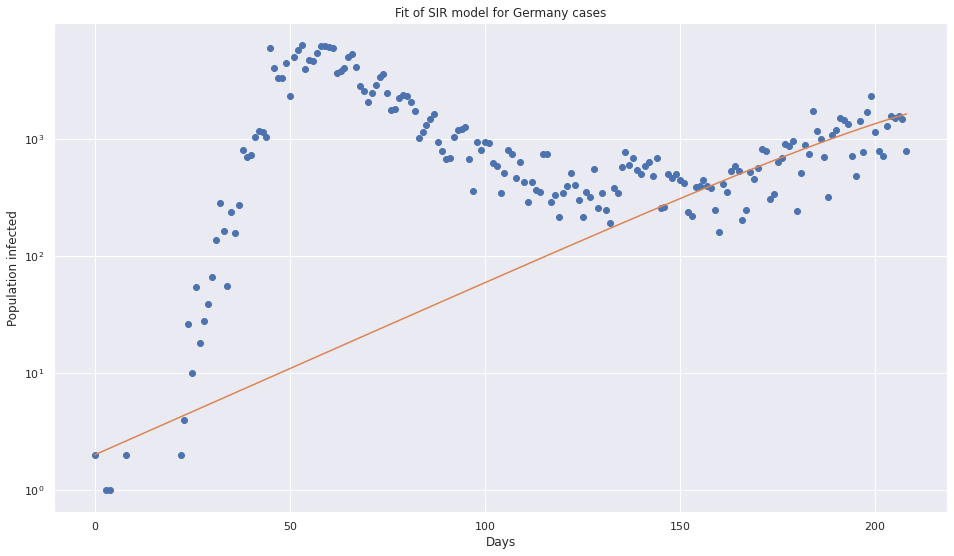

Optimal parameters: beta = 3.943447970304814  and gamma =  3.909502157627343
Basic Reproduction Number R0  1.0086828990773784
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [26]:
plt.semilogy(t, ydata, 'o')
plt.yscale('linear')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [27]:
df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [28]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=80000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))

popt=[0.4,0.1]
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))

# get the final fitted curve
fitted=fit_odeint(t, *popt)

/home/nick/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


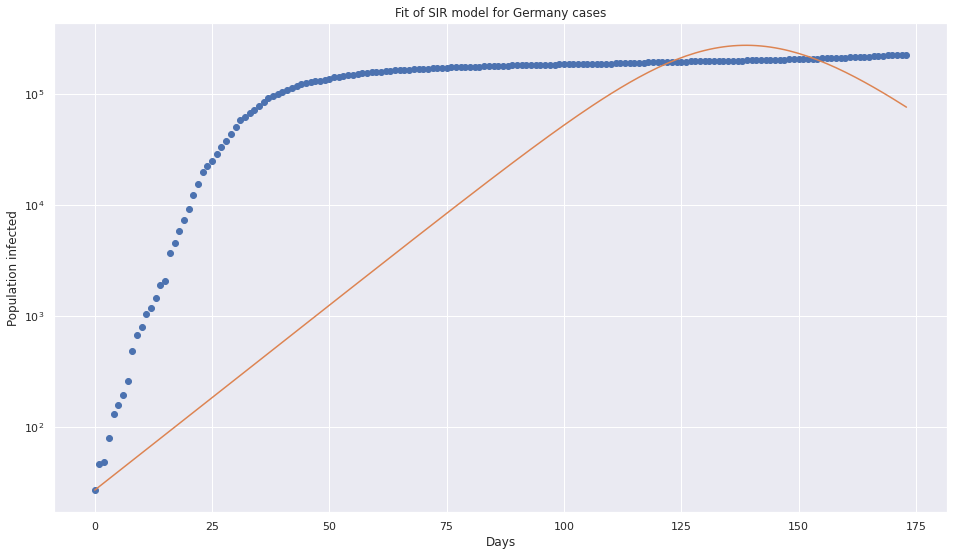

Optimal parameters: beta = 0.9396872289973365  and gamma =  0.8629396720937852
Basic Reproduction Number R0  1.0889373375514602
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [29]:
plt.semilogy(t, ydata, 'o')
plt.yscale('linear')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [30]:
def SIR(data):
    popt=[0.4,0.1]
    ydata = data
    t=np.arange(len(ydata))
    popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
    perr = np.sqrt(np.diag(pcov))

    # get the final fitted curve
    return fit_odeint(t, *popt)
     

In [31]:
pd_JH_data=pd.read_csv('../data/processed/COVID_relational_confirmed.csv',sep=';',parse_dates=[0])
pd_JH_data=pd_JH_data.sort_values('date',ascending=True).reset_index(drop=True).copy()

# TODO: get all countries
country_list=['Italy','US','Spain','Germany','Korea, South',]

test_data=pd_JH_data[((pd_JH_data['country']=='US')|
                      (pd_JH_data['country']=='Germany')|
                      (pd_JH_data['country']=='Spain'))
                     ]
test_data.head()

,date,state,country,confirmed
43,2020-01-22,no,Germany,0.0
83,2020-01-22,no,US,1.0
97,2020-01-22,no,Spain,0.0
308,2020-01-23,no,Germany,0.0
347,2020-01-23,no,US,1.0


In [32]:
ydata_test = np.array(test_data[test_data['country'] == 'Germany']['confirmed'][35:])
fitted_test = SIR(ydata_test)
#print(str(type(test)) + ' ' + str(test.shape))
#print(str(type(ydata)) + ' ' + str(ydata.shape))
if (ydata == ydata_test).all():
    if (fitted_test == fitted).all():
        print('Yeah')
    else:
        print('Bad')
else:
    print('very bad')

ValueError: operands could not be broadcast together with shapes (174,) (186,) 

In [ ]:
#testFrame = pd.DataFrame({'date':np.array(test_data['date'][35:]), 'SIR_Model':SIR(test)})

testFrame = pd.DataFrame({'date':test_data[test_data['country'] == 'Germany']['date'][35:]})
#len(testFrame['date'])
testFrame['SIR_static'] = fitted_test
testFrame['country'] = 'Germany' 


In [ ]:
testFrame.reset_index().head()

In [ ]:
test_data.reset_index().head()

In [33]:
pd_result_larg = test_data.reset_index().copy()
cols = ['SIR_static_x', 'SIR_static_y']

for each in pd.unique(test_data['country']):
    #print(each)
    ydata_SIR = np.array(test_data[test_data['country'] == each]['confirmed'][35:])    
    fitted_SIR = SIR(ydata_SIR)
    
    SIRFrame = pd.DataFrame({'date':test_data[test_data['country'] == each]['date'][35:]})    
    SIRFrame['SIR_static'] = fitted_SIR
    SIRFrame['country'] = each
    
    pd_result_larg = pd.merge(pd_result_larg, SIRFrame.reset_index()[['index', 'SIR_static', 'country']], on=['index', 'country'], how = 'left').copy()    
    
    if 'SIR_static_x' in pd_result_larg:
        pd_result_larg['SIR_static'] = pd_result_larg[cols].sum(1)
        pd_result_larg = pd_result_larg.drop(cols, 1)
    

ValueError: operands could not be broadcast together with shapes (174,) (186,) 

In [ ]:
ydata_test = np.array(pd_result_larg[pd_result_larg['country'] == 'Germany']['confirmed'][35:])
fitted_test = SIR(ydata_test)
#print(str(type(test)) + ' ' + str(test.shape))
#print(str(type(ydata)) + ' ' + str(ydata.shape))
if (ydata == ydata_test).all():
    if (fitted_test == fitted).all():
        print('Yeah')
    else:
        print('Bad')
else:
    print('very bad')